Area (steradians): 0.5982734638889997


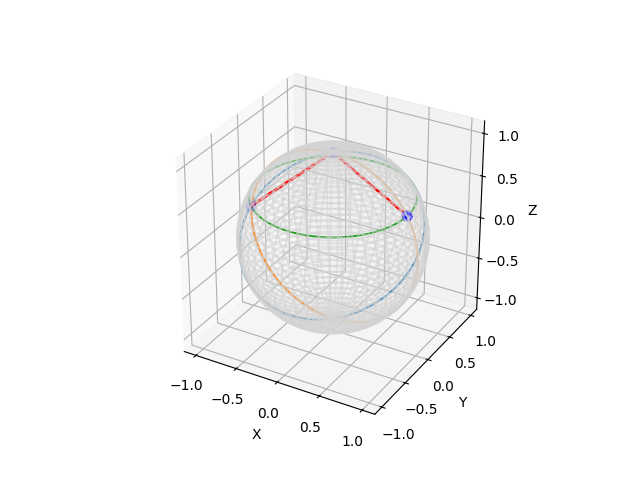

In [18]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401

plt.ion()

# ----------------------------------------------------------------------
# Plane builders – three ways to specify a circle‑defining plane
# ----------------------------------------------------------------------

def plane_from_axis_alpha(axis, alpha):
    """Old style (axis, angular radius)."""
    n = axis / norm(axis)
    return n, np.cos(alpha), alpha


def plane_from_point_tangent_on_sphere(p, t):
    """Point on unit sphere + tangent ⇒ great‑circle plane (through origin)."""
    p = p / norm(p)
    n = np.cross(p, t)
    if norm(n) < 1e-9:
        raise ValueError("tangent parallel to radius – plane undefined")
    n /= norm(n)
    d = 0.0
    alpha = np.pi / 2          # great circle => 90°
    return n, d, alpha


def plane_from_point_tangent_anywhere(p, t):
    """
    Totally general: P may be anywhere in ℝ³.
    Computes a plane that passes through P and contains the direction t.
    """
    n = np.cross(p, t)
    if norm(n) < 1e-9:
        raise ValueError("tangent colinear with position – plane undefined")
    n_unit = n / norm(n)
    d = np.dot(n_unit, p)          # signed distance
    if abs(d) >= 1.0:
        # No intersection with the unit sphere – we’ll warn but still return
        alpha = None
    else:
        alpha = np.arccos(abs(d))
    return n_unit, d, alpha


# ----------------------------------------------------------------------
# Select the right builder based on the data we receive
# ----------------------------------------------------------------------

def normal_d_alpha(spec):
    """
    Accept one of three encodings:
      1. (axis, scalar alpha)                  → old behaviour
      2. (point_on_sphere, tangent)            → great‑circle plane
      3. (arbitrary_point, tangent)            → general plane
    Decision rule:
      * If len(spec)==2 and spec[1] is scalar  → case 1
      * else if |point|≈1 (within 1 %)         → case 2
      * else                                   → case 3
    """
    p, q = spec
    if np.isscalar(q):
        return plane_from_axis_alpha(p, float(q))

    if abs(norm(p) - 1.0) < 1e-2:              # heuristically “on sphere”
        return plane_from_point_tangent_on_sphere(p, q)

    return plane_from_point_tangent_anywhere(p, q)


# ----------------------------------------------------------------------
# Geometry core – unchanged
# ----------------------------------------------------------------------

def intersect_two_planes(n1, d1, n2, d2, tol=1e-6):
    n = np.cross(n1, n2)
    if norm(n) < tol:
        return []
    A = np.vstack([n1, n2])
    b = np.array([d1, d2])
    x0 = A.T @ np.linalg.inv(A @ A.T) @ b
    a = np.dot(n, n)
    b2 = 2 * np.dot(x0, n)
    c2_val = np.dot(x0, x0) - 1
    disc = b2**2 - 4 * a * c2_val
    if disc < 0:
        return []
    t1 = (-b2 + np.sqrt(disc)) / (2 * a)
    t2 = (-b2 - np.sqrt(disc)) / (2 * a)
    return [x0 + t1 * n, x0 + t2 * n]


def compute_vertices(circle_specs, tol=1e-6):
    planes = [normal_d_alpha(s)[:2] for s in circle_specs
              if normal_d_alpha(s)[1]**2 < 1]   # skip planes that miss sphere
    candidates = []
    N = len(planes)
    for i in range(N):
        n1, d1 = planes[i]
        for j in range(i + 1, N):
            n2, d2 = planes[j]
            for p in intersect_two_planes(n1, d1, n2, d2, tol):
                if all(np.dot(n, p) >= d - tol for n, d in planes):
                    candidates.append(p / norm(p))
    unique = []
    for p in candidates:
        if not any(norm(p - q) < 1e-3 for q in unique):
            unique.append(p)
    return unique


def spherical_triangle_area(a, b, c):
    A = np.arccos(np.dot(b, c))
    B = np.arccos(np.dot(c, a))
    C = np.arccos(np.dot(a, b))
    s = 0.5 * (A + B + C)
    return 4 * np.arctan(
        np.sqrt(max(0, np.tan(s / 2) * np.tan((s - A) / 2)
                   * np.tan((s - B) / 2) * np.tan((s - C) / 2))))


def compute_area(vertices):
    if len(vertices) < 3:
        return 0.0
    centroid = np.mean(vertices, axis=0); centroid /= norm(centroid)
    total = 0.0
    m = len(vertices)
    for i in range(m):
        total += spherical_triangle_area(
            centroid, vertices[i], vertices[(i + 1) % m])
    return total


def sort_vertices(vertices):
    centroid = np.mean(vertices, axis=0); centroid /= norm(centroid)
    ref = np.array([1, 0, 0])
    if abs(np.dot(ref, centroid)) > 0.9:
        ref = np.array([0, 1, 0])
    e1 = np.cross(centroid, ref); e1 /= norm(e1)
    e2 = np.cross(centroid, e1)
    ang = [np.arctan2(np.dot(v, e2), np.dot(v, e1)) for v in vertices]
    return [v for _, v in sorted(zip(ang, vertices))]


# ----------------------------------------------------------------------
# Visualisation – uses α when available; skips planes that miss the sphere
# ----------------------------------------------------------------------

def plot_sphere_and_circles(circle_specs, vertices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    ax.plot_wireframe(np.outer(np.cos(u), np.sin(v)),
                      np.outer(np.sin(u), np.sin(v)),
                      np.outer(np.ones_like(u), np.cos(v)),
                      color='lightgray', alpha=0.5)

    # circles
    for spec in circle_specs:
        n, d, alpha = normal_d_alpha(spec)
        if alpha is None:          # no intersection
            print("Warning: plane misses the sphere – skipped in plot")
            continue
        u_dir = np.cross(n, np.array([0, 0, 1]))
        if norm(u_dir) < 1e-6:
            u_dir = np.cross(n, np.array([0, 1, 0]))
        u_dir /= norm(u_dir)
        v_dir = np.cross(n, u_dir)
        phis = np.linspace(0, 2 * np.pi, 200)
        pts = np.array([np.cos(alpha) * n +
                        np.sin(alpha) * (np.cos(phi) * u_dir +
                                         np.sin(phi) * v_dir)
                        for phi in phis])
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], lw=1.5)

    # polygon
    if vertices:
        verts = np.array(sort_vertices(vertices) + [vertices[0]])
        ax.plot(verts[:, 0], verts[:, 1], verts[:, 2],
                color='red', lw=2)
        ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2],
                   color='blue', s=50)

    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.show()


# ----------------------------------------------------------------------
# Demo
# ----------------------------------------------------------------------

if __name__ == '__main__':
    # Plane given by point on the sphere (great circle)
    p_on = np.array([1, 1, 0]) / np.sqrt(2)
    t_on = np.array([0, 0, 1])
    circle_1 = (p_on, t_on)

    # Plane given by arbitrary point 2 units out along +X, same tangent dir
    p_off = np.array([2.0, 0.0, 0.0])      # OFF the sphere
    t_off = np.array([0.0, 0.0, 1.0])
    circle_2 = (p_off, t_off)

    # Old‑style small circle
    circle_3 = (np.array([0, 0, 1]), np.deg2rad(60))

    circles = [circle_1, circle_2, circle_3]

    verts = compute_vertices(circles)
    print("Area (steradians):", compute_area(verts))
    plot_sphere_and_circles(circles, verts)
